# Tutorial Surprise UserKNN

En este práctico vamos a utilizar la biblioteca de Python [Surprise](http://surpriselib.com/) desarrollada por Nicolas Hug, para aprender sobre User KNN (Filtrado colaborativo basado en usuarios)

**Profesor**: Denis Parra

**Ayudantes**: Florencia Ferrer, Álvaro Labarca, Nicolás Sumonte, Jorge Facuse y Pablo Messina.


# Índice

>[Tutorial Surprise UserKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Como ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Preparar entorno](#scrollTo=P3K5VPZoGSYX)

>>[UserKNN](#scrollTo=2e0ZeZXzMhU3)

>>[Predecir el rating que le dará un usuario a un cierto item](#scrollTo=lEx2TVc1B5wk)

>>[Generar una lista de recomendaciones para un usuario](#scrollTo=dIVXNsQ8CCJV)

>>[Explorar los hiperparámetros del modelo UserKnn](#scrollTo=6_Kp3zRwJ9gv)

>>>[Evaluar en base a error de prediccion (RMSE y MAE)](#scrollTo=g55SDLmqCpUo)



# Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos

In [ ]:
!curl -L -o "u1.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1546k  100 1546k    0     0  1938k      0 --:--:-- --:--:-- --:--:-- 1938k


In [ ]:
!curl -L -o "u1.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  385k  100  385k    0     0   265k      0  0:00:01  0:00:01 --:--:--  265k


In [ ]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  230k  100  230k    0     0   437k      0 --:--:-- --:--:-- --:--:-- 11.8M


Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, item, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/).

# Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [ ]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [ ]:
# Ver la o las filas específicas del item con id = 1653
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo

In [ ]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [ ]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [ ]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Como ver la información de una o más películas
Para esto se hace 2 pasos, 
1. Determinar los índices de las películas
2. Pedir a `info_file` las columnas
3. (adicional) Indicar alguna columna en específico

In [ ]:
# Ejemplo de cómo visualizar titulos de peliculas en base a sus IDs

# Paso 1
pelis = [5,4,1]
# Paso 2
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá como obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna

In [ ]:
# Paso 3, acceder solo a columnas específicas
info_file.loc[pelis]['title']

movieid
5       Copycat (1995)
4    Get Shorty (1995)
1     Toy Story (1995)
Name: title, dtype: object

## Preparar entorno
Primero es necesario instalar una librería para realizar recomendaciones. Esta se llama [***Surprise***](https://github.com/NicolasHug/Surprise)

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Luego necesitamos importar Surprise y numpy, librerías que utilizaremos en este práctico

In [ ]:
import surprise
import numpy as np
from collections import defaultdict

## UserKNN

Probar método de recomendación basado en ***UserKNN***

Antes de generar el recomendador, hay que convertir los datos a un formato que sea soportado por la librería Surprise. Para esto, utilizamos la función Reader que convierte una base de datos de un archivo al formato deseado.

In [ ]:
from surprise.model_selection import PredefinedKFold
reader = surprise.Reader(line_format='user item rating timestamp', sep='\t', rating_scale=(1,5))
data = surprise.Dataset.load_from_folds([("u1.base", "u1.test")], reader=reader)
pkf = PredefinedKFold()
trainset, testset = next(pkf.split(data))

Se puede ver que al objeto Reader le estamos entregando:
* ***line_format:*** El orden de las columnas que representan cada elemento del dataset (debe tener el formato que se muestra y estar separadas por espacios).
* ***sep:*** El delimitador del archivo, en este caso las columnas estan separadas por un tab (\t)
* ***rating_scale:*** La escala usada en los ratings (en este caso los ratings van del $1$ al $5$)

Luego, usamos el módulo Dataset de Surprise para usar el objeto Reader para leer los datos de un archivo. En este caso, ya que tenemos el set de entrenamiento y testeo en archivos separados, usamos la función ***load_from_folds*** que recibe una lista de tuplas con los nombres de los archivos de entrenamiento y testeo. Existen también funciones que permiten leer todos los items de un solo archivo, cargar datasets predefinidos o importarlos desde un dataframe de Pandas. Pueden leer estas aplicaciones en la [_documentación_](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_builtin).

Finalmente, la función ***pkf.split*** entrega un generador que itera sobre los archivos de entrenamiento y testeo que definimos en la lista que le entregamos a ***load_from_folds***. En este caso, como solo contamos con un archivo de entrenamiento y uno de testeo, invocamos la función ***next*** para definir los datasets como el primer output del generador.

Finalmente declaramos el objeto recomendador que vamos a usar:

In [ ]:
# Declarar el objeto recomendador UserKnn
from surprise import accuracy
myUserKnn = surprise.KNNBasic(k=7, sim_options={'name': 'pearson', 'user_based': True})

Se puede ver que al objeto recomendador le estamos entregando:
* ***k***: La cantidad de vecinos que se considerarán.
* ***sim_options:*** Diccionario que contiene los detalles de la función de similaridad que se usará. Dentro de este, definimos:
  * ***name:*** La función de similitud. Puede ser Pearson, Cosine, etc.
  * ***user_based:*** Booleano que define si el método será basado en usuarios o items.

In [ ]:
# Entrenamos el modelo con los datos existentes usando la función fit del objeto recomendador.

myUserKnn.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


## Predecir el rating que le dará un usuario a un cierto item

Según el modelo de recomendación UserKnn, qué rating le dará el usuario 457 al item 37?



In [ ]:
myUserKnn.predict("457", "37")

Prediction(uid='457', iid='37', r_ui=None, est=2.161717349048707, details={'actual_k': 6, 'was_impossible': False})

## Generar una lista de recomendaciones para un usuario

Generar lista de 10 recomendaciones para el usuario con ID 457. Indique qué películas son con todas sus columnas. (Recuerde el comando `loc` vista anteriormete)

Para obtener las predicciones de una lista de elementos, se debe llamar a la función ***.test()*** de el objeto recomendador. Sin embargo, esta función solo recibe objetos del tipo testset de la misma librería.

Para esto, se usa la función ***.build_anti_testset()*** a partir de un objeto trainset que entrega un objeto ***testset*** con todos los pares usuario-item que no tengan un valor fijado en el trainset.

In [ ]:
a_testset = trainset.build_anti_testset()
predictions = myUserKnn.test(a_testset)

Luego, usamos la función ***get_top_n*** sugerida en la [documentación](https://surprise.readthedocs.io/en/stable/FAQ.html) la cual recibe todas las predicciones para cada item-usuario desconocido (que tenemos guardado en la variable ***predictions***) y retorna un diccionario que recibe de llave el *id* de un usuario y retorna una lista de tuplas con el id de los items recomendados y su rating predicho.

In [ ]:
def get_top_n(predictions, n=10):
    """Devuelve las N-mejores recomendaciones para cada usuario de un set de predicción.

    Args:
        predictions(lista de objetos Prediction): La lista de predicción obtenida del método test.
        n(int): El número de recomendaciónes por usuario

    Returns:
    Un diccionario donde las llaves son ids de usuario y los valores son listas de tuplas:
        [(item id, rating estimation), ...] de tamaño n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
top_n = get_top_n(predictions, n=10)
print(top_n["457"])

[('814', 5), ('1122', 5), ('1189', 5), ('1201', 5), ('1443', 5), ('1467', 5), ('1491', 5), ('1500', 5), ('1450', 5), ('1512', 5)]


In [ ]:
info_file.loc[[int(m[0]) for m in top_n["457"]]]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
814,"Great Day in Harlem, A (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Great%20Day%2...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1122,They Made Me a Criminal (1939),01-Jan-1939,NaN,http://us.imdb.com/M/title-exact?They%20Made%2...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1189,Prefontaine (1997),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Prefontaine%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1201,Marlene Dietrich: Shadow and Light (1996),02-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Marlene%20Die...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1443,8 Seconds (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?8%20Seconds%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1491,Tough and Deadly (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Tough%20and%2...,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Explorar los hiperparámetros del modelo UserKnn

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Usuarios), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error.

In [ ]:
k_values = [5, 10, 30, 50, 70, 100] # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:
  myUserKnn = surprise.KNNBasic(k=k, sim_options={'name': 'cosine', 'user_based': True})
  myUserKnn.fit(trainset)
  predictions = myUserKnn.test(testset)
  rmse_values.append(accuracy.rmse(predictions))
  mae_values.append(accuracy.mae(predictions))

print('RMSE:', rmse_values)
print('MAE:', mae_values)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0864
MAE:  0.8538
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0453
MAE:  0.8230
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0232
MAE:  0.8060
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0205
MAE:  0.8053
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0206
MAE:  0.8063
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8090
RMSE: [1.0864423317092684, 1.045254266559351, 1.0231702636288682, 1.0205332262288298, 1.0205845989659934, 1.0223336705661499]
MAE: [0.8538450592793959, 0.8229549183459476, 0.8059508492475066, 0.8053176429216996, 0.8062942847936805, 0.808975885654256]


### Evaluar en base a error de prediccion (RMSE y MAE)

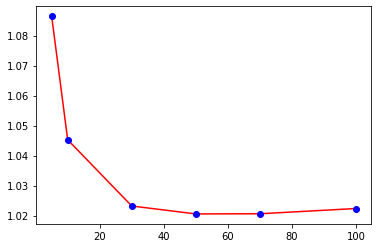

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

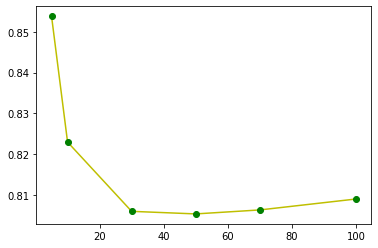

In [ ]:
plt.plot(k_values, mae_values, 'y-')
plt.plot(k_values, mae_values, 'go')
plt.show()

Según los resultados: ¿ qué numero de vecinos es mejor para hacer recomendaciones con un menor error de predicción ?

Podemos observar que el menor error se da con **k=50**, por lo tanto podemos reentrenar con este valor y ver loa resultados.

In [ ]:
myUserKnn = surprise.KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': True})
myUserKnn.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [ ]:
predictions = myUserKnn.test(a_testset)
top_n = get_top_n(predictions, n=10)
print(top_n["457"])
pelis_userKnn = np.array([m[0] for m in top_n["457"]]).astype(int)
info_file.loc[pelis_userKnn]['title']

[('814', 5), ('1122', 5), ('1201', 5), ('1293', 5), ('1467', 5), ('1500', 5), ('1450', 5), ('1512', 5), ('1599', 5), ('1472', 5)]


movieid
814                  Great Day in Harlem, A (1994)
1122                They Made Me a Criminal (1939)
1201    Marlene Dietrich: Shadow and Light (1996) 
1293                               Star Kid (1997)
1467          Saint of Fort Washington, The (1993)
1500                     Santa with Muscles (1996)
1450                        Golden Earrings (1947)
1512        World of Apu, The (Apur Sansar) (1959)
1599                 Someone Else's America (1995)
1472         Visitors, The (Visiteurs, Les) (1993)
Name: title, dtype: object